In [1]:
from modules.tokenizer_wrapper import TokenizerWrapper
from modules.PDFLoader import LoadCorpus
from modules.Corpus_Builder import DatasetBuilder
from modules.Transformers import TransformerBlock
from modules.HelperClasses import LayerNorm
#from modules.GPT import GPT
#from modules.config import config
import config as ds_config
import pandas as pd
import numpy as np
import csv
import config as model_config

In [3]:
reader = LoadCorpus()
reader.CreateCorpus()
tokenizer = TokenizerWrapper('gpt2')
db = DatasetBuilder(ds_config.corpus_file,ds_config.bin_dir,ds_config.output_dir
                        ,read_batch_size=1024,tokenizer=tokenizer)
db.build()

./input/
Reading File: 01MDC010116BADB4521C423465C9679DBFA22845C7D.PDF
Reading File: 02MD787706E669D641C090B415DBE22DEE29.PDF
Reading File: 03MD945692290C104C5595AEDAC89AE78788.PDF
Reading File: 04MD5127742FD0914D54B5EC4ECA8076F325.PDF
Reading File: 05MD56DF4232873F466191DC23F39F1012DD.PDF
Reading File: 06MDE170516F633150EBCFE438084174F7DECCDC20C.PDF
Reading File: 07MIP0101168C51C4CB845342D09E8A4A613B1F1C6D.PDF
Reading File: 08MDROA112016989330DF1FF9494784DAC32B488E6AE4.PDF
Reading File: 09MDD593B2F2D48648C8AB3D37625C9F245D.PDF
Reading File: 100MD03042023F2C548759A2C4E429F295F9A9FC5168F.PDF
Reading File: 101MDPPD80EBE808A91E45CE9BE6B989C188F877.PDF
Reading File: 102MDITSERVICES56B33FD530B1433187D75CB7C06C8F70.PDF
Reading File: 103MDCAPITALREQUIREMENTS50C9076B7D494F259CC908D618297293.PDF
Reading File: 104MDINVESTMENTPORTFOLIOC6B7053A02894342A00142968C70FC82.PDF
Reading File: 105MDPRUDENTIALREGULATIONSAIFISCF490815D13A4EE9BD3D48B79DD89285.PDF
Reading File: 106MDNBFCS1910202343073E3EF57A4

49it [00:01, 34.16it/s]


Total Number of Rows Read: 51167


Writing train.bin: 100%|██████████| 44308/44308 [00:00<00:00, 223659.60it/s]


train.bin.written:1,563,882 tokens


Writing val.bin: 100%|██████████| 4901/4901 [00:00<00:00, 249142.92it/s]

val.bin.written:165,583 tokens

📊 Tokenization Summary
Total tokens processed: 1,729,465
Unique token IDs used: 16,765


In [5]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
#def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    
#    if split == 'train':
#        data = np.memmap(model_config.bin_dir+'/train.bin', dtype=np.uint16, mode='r')
#    else:
#        data = np.memmap(model_config.bin_dir+'val.bin', dtype=np.uint16, mode='r')
#    ix = torch.randint(len(data) - block_size, (batch_size,))
#    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
#    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
#    if device_type == 'cuda':
 #       # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
 #       x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
 #   else:
 #       x, y = x.to(device), y.to(device)
 #   return x, y


## Step 4: Define the SLM Model Architecture

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

#class LayerNorm(nn.Module):
#    def __init__(self, ndim, bias):
#        super().__init__()
#        self.weight = nn.Parameter(torch.ones(ndim))
#        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
 #   def forward(self, x):
 #       return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)
    

    
#class CausalSelfAttention(nn.Module):
#    def __init__(self, config):
#        super().__init__()
#        assert config.n_embd % config.n_head == 0
#        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
#        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
#        self.attn_dropout = nn.Dropout(config.dropout)
#        self.resid_dropout = nn.Dropout(config.dropout)
##        self.n_head = config.n_head
 #       self.n_embd = config.n_embd
 #       self.flash = hasattr(F, 'scaled_dot_product_attention')
 #       if not self.flash:
 #           self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
 #                                      .view(1, 1, config.block_size, config.block_size))

 #   def forward(self, x):
 #       B, T, C = x.size()
 ##       q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
  #      k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
 #       q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
 #       v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

 #       if self.flash:
 #           y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
 #       else:
 #           att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
 #           att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
 #           att = F.softmax(att, dim=-1)
 #           att = self.attn_dropout(att)
 #           y = att @ v

 #       y = y.transpose(1, 2).contiguous().view(B, T, C)
 #       y = self.resid_dropout(self.c_proj(y))
 #       return y


#class MLP(nn.Module):
#    def __init__(self, config):
#        super().__init__()
#        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
#        self.gelu = nn.GELU()
#        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
#        self.dropout = nn.Dropout(config.dropout)
#    def forward(self, x):
#        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)



class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([TransformerBlock(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



c:\Users\balaj\anaconda3\envs\RAG\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=12,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

## Step 5: Define the loss function

In [6]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = db.get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [7]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 40000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

## Step 7: Define SLM Training Configuration Part 2

In [8]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

C:\Users\balaj\AppData\Local\Temp\ipykernel_24092\2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


## Step 8: Pre-train the SLM

In [11]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params_V2.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = db.get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/40000 [00:00<?, ?it/s]c:\Users\balaj\anaconda3\envs\RAG\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  1%|▏         | 500/40000 [03:37<4:39:16,  2.36it/s]

Epoch 500: train loss 9.8395, val loss 9.8398
The current learning rate: 0.00007


  2%|▏         | 999/40000 [09:39<4:04:11,  2.66it/s]  c:\Users\balaj\anaconda3\envs\RAG\Lib\site-packages\torch\optim\lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  2%|▎         | 1000/40000 [09:40<4:07:37,  2.62it/s]

Epoch 1000: train loss 8.9447, val loss 8.9567
The current learning rate: 0.00010


  4%|▍         | 1500/40000 [15:33<3:59:08,  2.68it/s]  

Epoch 1500: train loss 8.1738, val loss 8.1831
The current learning rate: 0.00010


  5%|▌         | 2000/40000 [21:24<3:54:56,  2.70it/s]  

Epoch 2000: train loss 7.5076, val loss 7.5419
The current learning rate: 0.00010


  6%|▋         | 2500/40000 [27:17<3:44:44,  2.78it/s]  

Epoch 2500: train loss 6.9759, val loss 7.0164
The current learning rate: 0.00010


  8%|▊         | 3000/40000 [33:10<3:45:51,  2.73it/s]  

Epoch 3000: train loss 6.5853, val loss 6.6273
The current learning rate: 0.00010


  9%|▉         | 3500/40000 [39:04<3:43:46,  2.72it/s]  

Epoch 3500: train loss 6.2563, val loss 6.3158
The current learning rate: 0.00010


 10%|█         | 4000/40000 [44:57<4:30:12,  2.22it/s]  

Epoch 4000: train loss 5.9954, val loss 6.0642
The current learning rate: 0.00011


 11%|█▏        | 4500/40000 [50:49<3:35:56,  2.74it/s]  

Epoch 4500: train loss 5.7943, val loss 5.8751
The current learning rate: 0.00011


 12%|█▎        | 5000/40000 [56:41<3:29:17,  2.79it/s]  

Epoch 5000: train loss 5.5981, val loss 5.7089
The current learning rate: 0.00011


 14%|█▍        | 5500/40000 [1:02:33<3:30:44,  2.73it/s]

Epoch 5500: train loss 5.4435, val loss 5.5457
The current learning rate: 0.00011


 15%|█▌        | 6000/40000 [1:08:23<3:28:22,  2.72it/s]  

Epoch 6000: train loss 5.2798, val loss 5.4030
The current learning rate: 0.00012


 16%|█▋        | 6500/40000 [1:14:14<3:21:41,  2.77it/s]  

Epoch 6500: train loss 5.1362, val loss 5.2751
The current learning rate: 0.00012


 18%|█▊        | 7000/40000 [1:20:08<3:19:42,  2.75it/s]  

Epoch 7000: train loss 5.0201, val loss 5.1607
The current learning rate: 0.00012


 19%|█▉        | 7500/40000 [1:26:05<3:24:34,  2.65it/s]  

Epoch 7500: train loss 4.8995, val loss 5.0629
The current learning rate: 0.00013


 20%|██        | 8000/40000 [1:31:52<3:59:15,  2.23it/s]  

Epoch 8000: train loss 4.7916, val loss 4.9555
The current learning rate: 0.00013


 21%|██▏       | 8500/40000 [1:37:39<3:09:13,  2.77it/s]  

Epoch 8500: train loss 4.6836, val loss 4.8719
The current learning rate: 0.00014


 22%|██▎       | 9000/40000 [1:43:24<3:07:24,  2.76it/s]  

Epoch 9000: train loss 4.5812, val loss 4.7814
The current learning rate: 0.00014


 24%|██▍       | 9500/40000 [1:49:11<3:07:48,  2.71it/s]  

Epoch 9500: train loss 4.4896, val loss 4.6960
The current learning rate: 0.00015


 25%|██▌       | 10000/40000 [1:54:59<3:03:31,  2.72it/s] 

Epoch 10000: train loss 4.3946, val loss 4.6215
The current learning rate: 0.00015


 26%|██▋       | 10500/40000 [2:10:11<7:35:30,  1.08it/s]    

Epoch 10500: train loss 4.3094, val loss 4.5342
The current learning rate: 0.00016


 28%|██▊       | 11000/40000 [2:22:16<4:41:32,  1.72it/s]    

Epoch 11000: train loss 4.2250, val loss 4.4796
The current learning rate: 0.00016


 29%|██▉       | 11500/40000 [2:32:45<3:57:25,  2.00it/s]   

Epoch 11500: train loss 4.1370, val loss 4.3977
The current learning rate: 0.00017


 30%|███       | 12000/40000 [2:40:44<4:10:32,  1.86it/s]  

Epoch 12000: train loss 4.0538, val loss 4.3275
The current learning rate: 0.00017


 31%|███▏      | 12500/40000 [2:46:42<2:46:19,  2.76it/s]  

Epoch 12500: train loss 3.9779, val loss 4.2693
The current learning rate: 0.00018


 32%|███▎      | 13000/40000 [2:52:37<2:37:15,  2.86it/s]  

Epoch 13000: train loss 3.9122, val loss 4.2084
The current learning rate: 0.00019


 34%|███▍      | 13500/40000 [2:58:36<2:37:51,  2.80it/s]  

Epoch 13500: train loss 3.8226, val loss 4.1376
The current learning rate: 0.00019


 35%|███▌      | 14000/40000 [3:04:39<2:43:07,  2.66it/s]  

Epoch 14000: train loss 3.7471, val loss 4.0821
The current learning rate: 0.00020


 36%|███▋      | 14500/40000 [3:10:40<2:33:23,  2.77it/s]  

Epoch 14500: train loss 3.6788, val loss 4.0242
The current learning rate: 0.00021


 38%|███▊      | 15000/40000 [3:16:38<2:36:54,  2.66it/s]  

Epoch 15000: train loss 3.6102, val loss 3.9712
The current learning rate: 0.00021


 39%|███▉      | 15500/40000 [3:22:41<2:37:06,  2.60it/s]  

Epoch 15500: train loss 3.5499, val loss 3.9156
The current learning rate: 0.00022


 40%|████      | 16000/40000 [3:28:46<2:59:24,  2.23it/s]  

Epoch 16000: train loss 3.4732, val loss 3.8620
The current learning rate: 0.00023


 41%|████▏     | 16501/40000 [3:37:00<295:40:04, 45.30s/it]

Epoch 16500: train loss 3.4016, val loss 3.8147
The current learning rate: 0.00024


 43%|████▎     | 17001/40000 [3:42:26<283:03:15, 44.31s/it]

Epoch 17000: train loss 3.3375, val loss 3.7773
The current learning rate: 0.00024


 44%|████▍     | 17500/40000 [3:45:21<2:13:36,  2.81it/s]  

Epoch 17500: train loss 3.2749, val loss 3.7259
The current learning rate: 0.00025


 45%|████▌     | 18001/40000 [3:53:17<276:59:16, 45.33s/it]

Epoch 18000: train loss 3.2005, val loss 3.6707
The current learning rate: 0.00026


 46%|████▋     | 18501/40000 [3:58:43<245:53:49, 41.18s/it]

Epoch 18500: train loss 3.1481, val loss 3.6485
The current learning rate: 0.00027


 48%|████▊     | 19000/40000 [4:01:38<2:03:25,  2.84it/s]  

Epoch 19000: train loss 3.0849, val loss 3.6067
The current learning rate: 0.00028


 49%|████▉     | 19501/40000 [4:09:34<256:42:32, 45.08s/it]

Epoch 19500: train loss 3.0185, val loss 3.5582
The current learning rate: 0.00028


 50%|█████     | 20001/40000 [4:15:02<254:39:59, 45.84s/it]

Epoch 20000: train loss 2.9459, val loss 3.5074
The current learning rate: 0.00029


 51%|█████▏    | 20500/40000 [4:17:58<1:55:30,  2.81it/s]  

Epoch 20500: train loss 2.8966, val loss 3.4856
The current learning rate: 0.00030


 53%|█████▎    | 21001/40000 [4:25:54<233:35:34, 44.26s/it]

Epoch 21000: train loss 2.8345, val loss 3.4416
The current learning rate: 0.00031


 54%|█████▍    | 21500/40000 [4:28:49<1:48:33,  2.84it/s]  

Epoch 21500: train loss 2.7845, val loss 3.4131
The current learning rate: 0.00032


 55%|█████▌    | 22001/40000 [4:36:45<227:00:38, 45.40s/it]

Epoch 22000: train loss 2.7165, val loss 3.3864
The current learning rate: 0.00032


 56%|█████▋    | 22501/40000 [4:42:11<200:06:05, 41.17s/it]

Epoch 22500: train loss 2.6551, val loss 3.3616
The current learning rate: 0.00033


 58%|█████▊    | 23001/40000 [4:47:37<214:41:17, 45.47s/it]

Epoch 23000: train loss 2.6015, val loss 3.3199
The current learning rate: 0.00034


 59%|█████▉    | 23501/40000 [4:53:03<207:12:05, 45.21s/it]

Epoch 23500: train loss 2.5476, val loss 3.2937
The current learning rate: 0.00035


 60%|██████    | 24001/40000 [4:58:29<201:27:08, 45.33s/it]

Epoch 24000: train loss 2.4844, val loss 3.2625
The current learning rate: 0.00036


 61%|██████▏   | 24501/40000 [5:03:55<195:20:10, 45.37s/it]

Epoch 24500: train loss 2.4325, val loss 3.2440
The current learning rate: 0.00036


 62%|██████▎   | 25000/40000 [5:06:51<1:27:18,  2.86it/s]  

Epoch 25000: train loss 2.3758, val loss 3.2229
The current learning rate: 0.00037


 63%|██████▎   | 25034/40000 [5:09:34<3:05:04,  1.35it/s]  


KeyboardInterrupt: 

## Step 9: Plot the SLM Loss Function

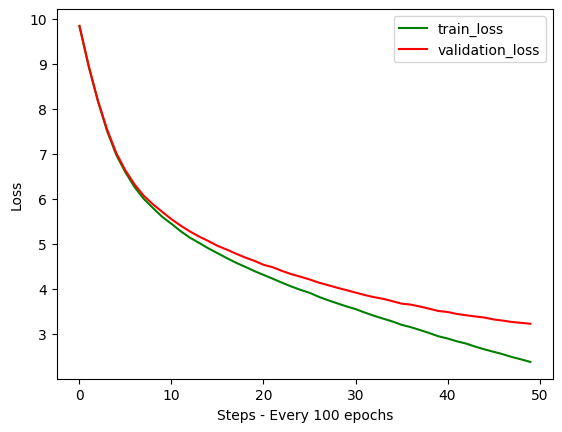

In [12]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [9]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params_V2.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [10]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
sentence = "Digital KYC is"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Digital KYC is required for exercising the investors at major net renewal,  the SPVs and differently 26.
AIFIs shall be review (list of the rules and guidelines guaranteed interestable) size of the cash flow hedge floating for the existing debt securities issued by them are adequately review.
7.2 Investment in unrated CB: 7.1 Business Risk Weighted Business for and Commodity Risk Management Framework (DoR) Directions,  2022
43 2.FMR1/20.45.4/ seeks to the closure of banks projects,  would,  backed securities to avail control limit by inclusion of Tier 2 capital).
AIFIs may be withoutfeit Interest Classiple 5.3.1 The rate of excess relative of the ratio of USD 1, 50, 000 per cent of the assets during the year.
Interest may be paid on income from contingent shortfall.
They should be included in the following entities having a minimum capital calculations of regulatory scope of approach (


In [11]:
sentence = "Transaction monitoring in banks"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Transaction monitoring in banks prescribed by the RBI issued to time 85.1 If an Interbank A framework is held under the ODI obligation.
However,  the Reserve Bank of India,  its Exchanges shall take appropriate posture of the cash variation in each challenger grace period,  and still a certificate to be included in the shortfall shall be recorded in the NPA ceiling of 45 governing stop portion.
(c) Loan charges shall not be well fixed income categories of only special posted from the Regulatory Time Profit Distribution Exchange by the Reserve Bank of India (GoI).
Where part oftain deposits are held to a new hedge holder.
In addition,  its standing / disclose the General Manager of the mechanics, Submission shall be suitably granted.
i.e.g.
Before issuance of this purportedly issued by a clear interest into a dedicated induct ahuman resources acquired by it is not in a particular clause,  the individual shall enable a qualifying criterion for both incremental provisioning for


In [12]:
sentence = "how much capital is required for basel"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

how much capital is required for basel X.
(iii) With regard to the credit rating of these business(s should be gone by the floor) to the board acts of the banking companies in addition to which the policy issued are legally enforceable.
(iii) showing the maturity and diverable below the results of these controls and brokers strongly initiate issues.
(iv) DownAGAT recognized by SEs a clearing services may result of the second economicallyiety shall be classified in the following policy: (i) Internal Reserves as a) Total of the bank have direct reporting information within the floating rate of 15 per their income/ acquisition by the AIFIs or an arrangement of the Government partnership
(j) Investments continue to be included under the Credit Exposure as the country.
(iii) amended/11/debentures granted to investment in a bank/ Deposits of aThey of timely overdue contracts,  etc.
(v) Credit Interest shall be calculated as the gross and is not in
